In [1]:
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import log_loss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


plt.style.use("ggplot")

df = pd.read_csv("processed/2.csv")
df.head()

,review_time,card_id,rating,review_state,is_learn_start,sequence_group,last_learn_start,mask,delta_t,i,delta_t_f,t_bin,t_history,r_history,t_f_history,y
0,1658184894444,1230430486697,3,0,True,1,1,True,0,1,0.00s,1.00,NaN,NaN,NaN,1
1,1658248040951,1230430486697,3,0,False,1,1,True,63146,2,17.54h,47434.81,0,3,0.00s,1
2,1659287345928,1230430486697,3,1,False,1,1,True,1039304,3,12.03d,980052.78,"0,63146","3,3","0.00s,17.54h",1
3,1664304919242,1230430486697,3,1,False,1,1,True,5017573,4,58.07d,3764970.74,"0,63146,1039304","3,3,3","0.00s,17.54h,12.03d",1
4,1657068143827,1230430623643,3,0,True,2,2,True,0,1,0.00s,1.00,NaN,NaN,NaN,1


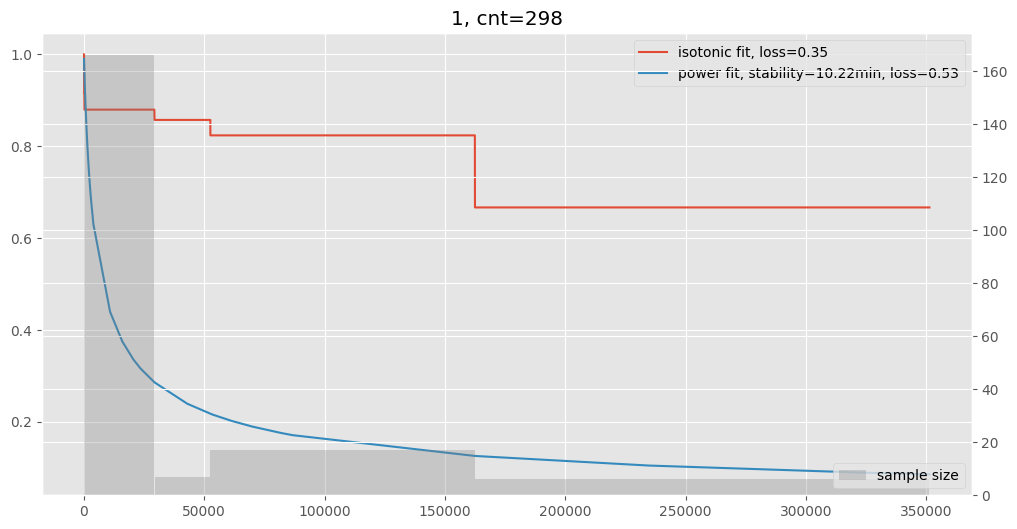

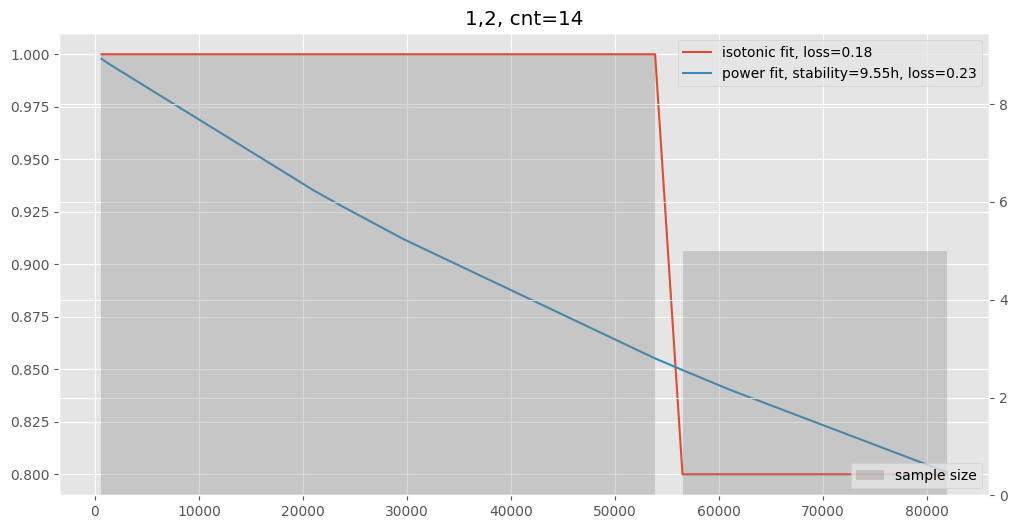

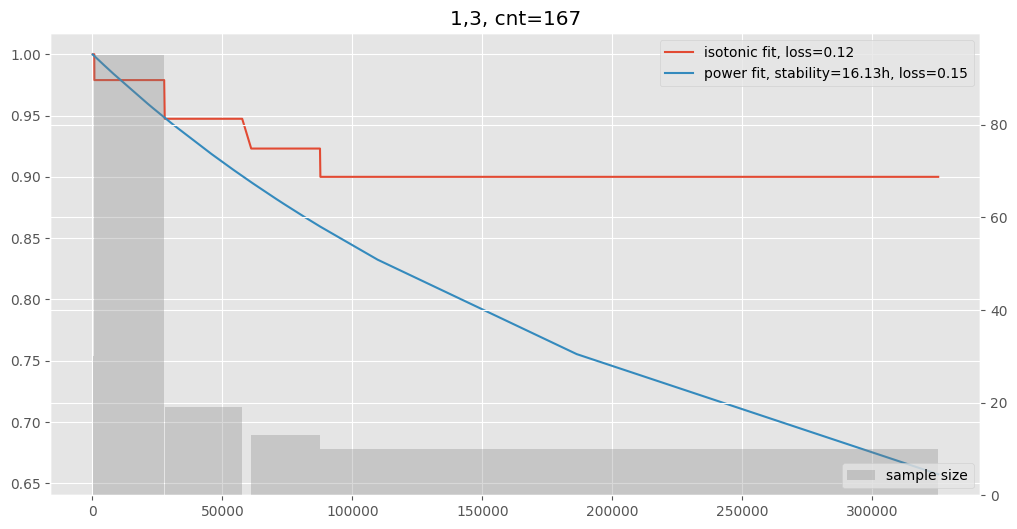

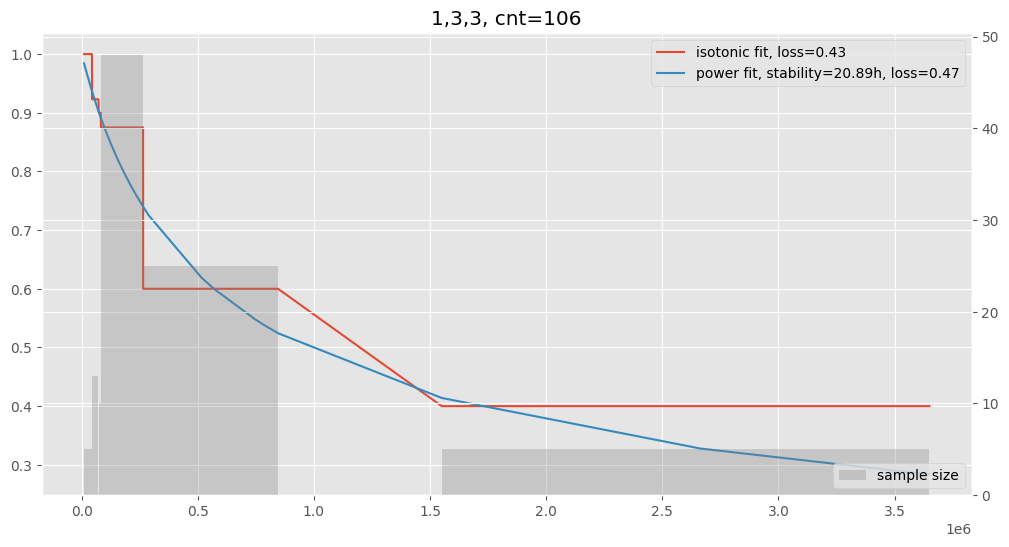

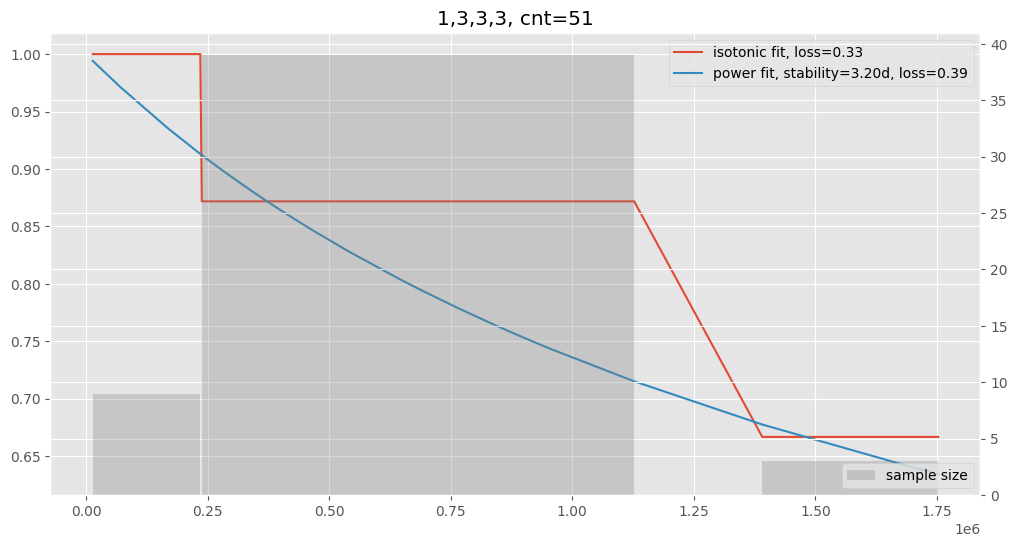

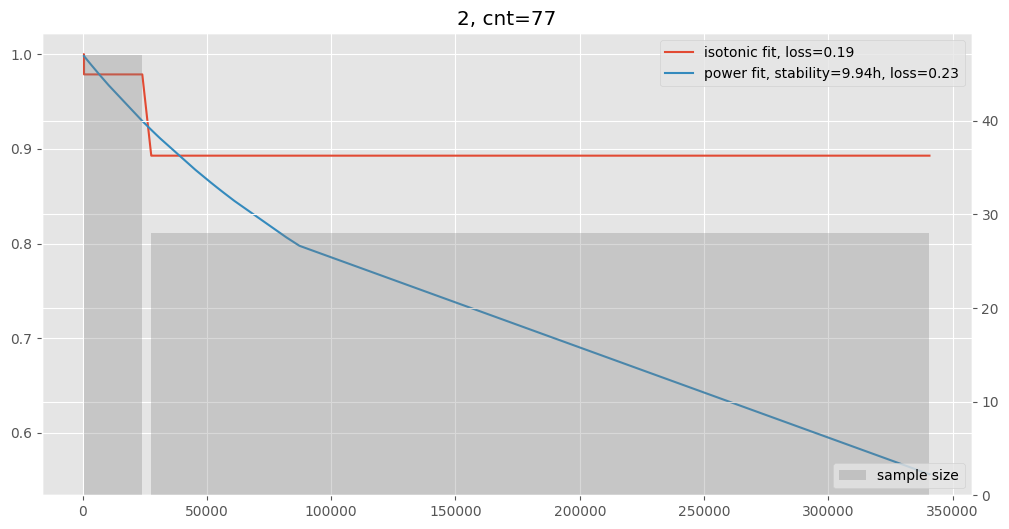

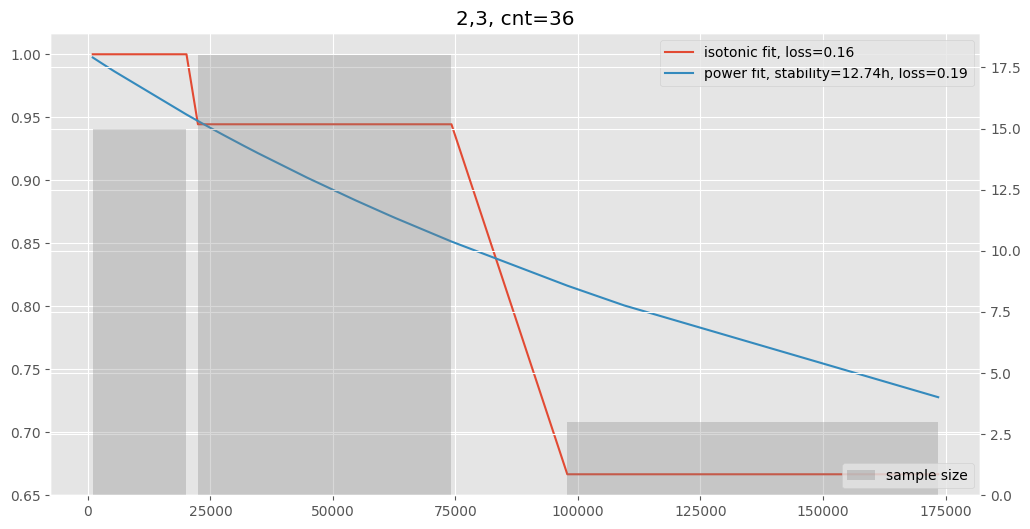

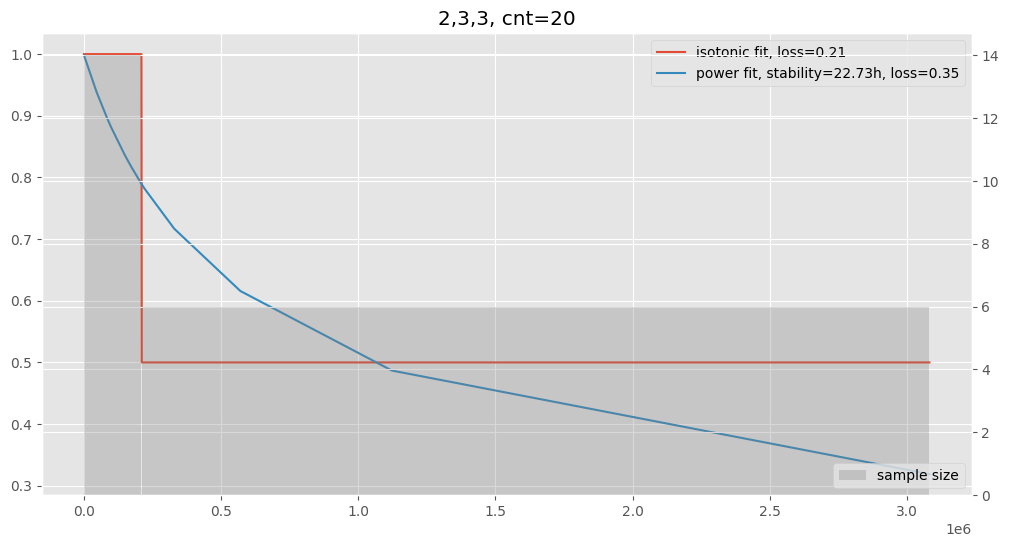

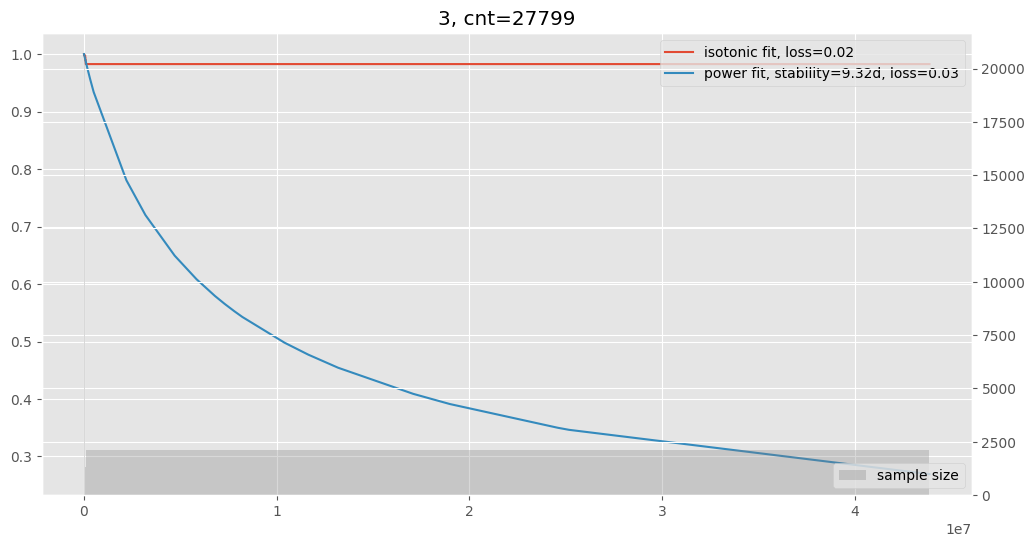

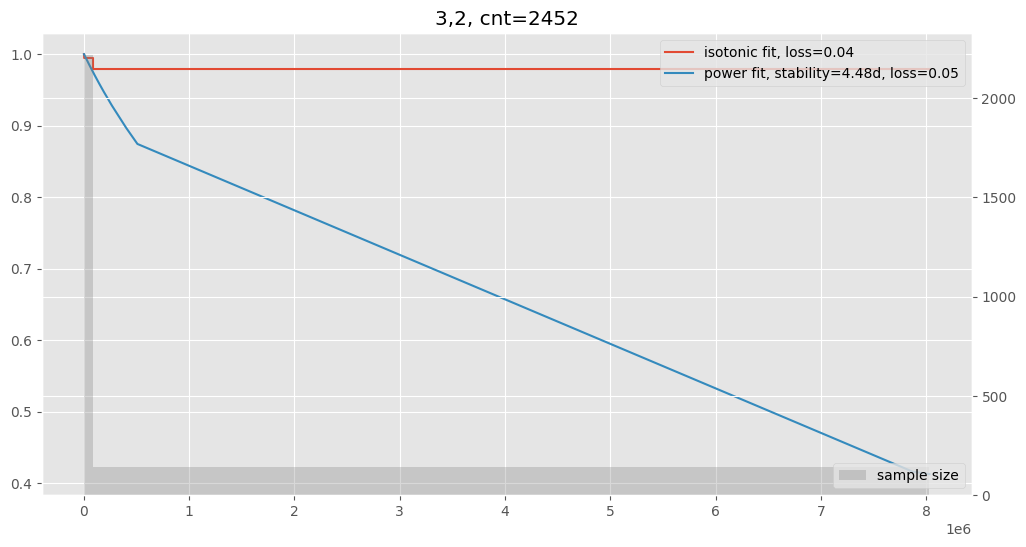

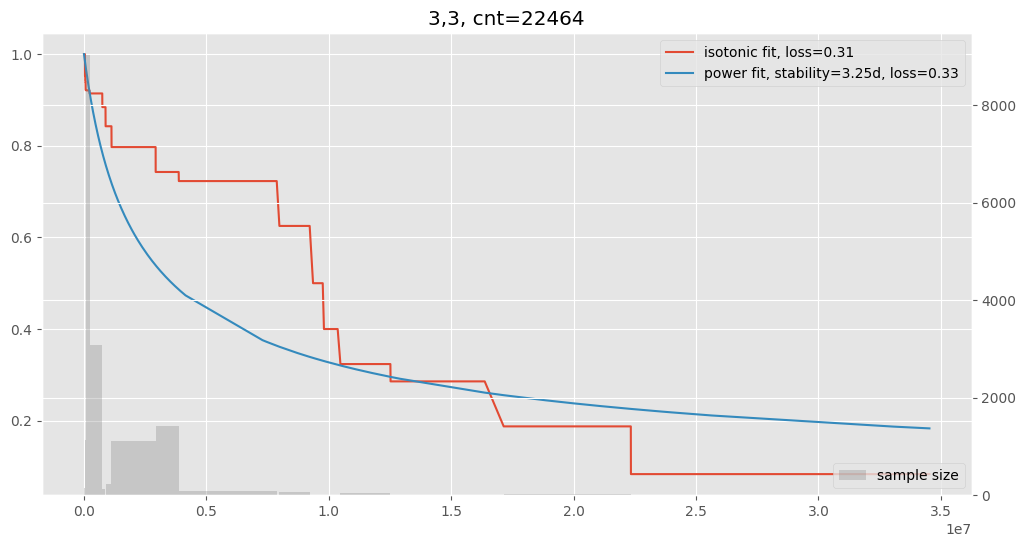

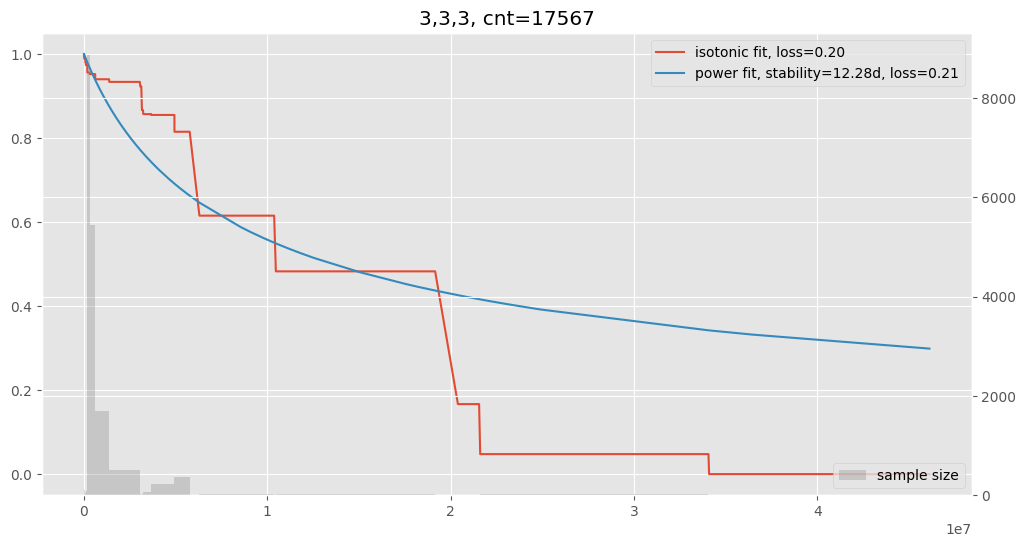

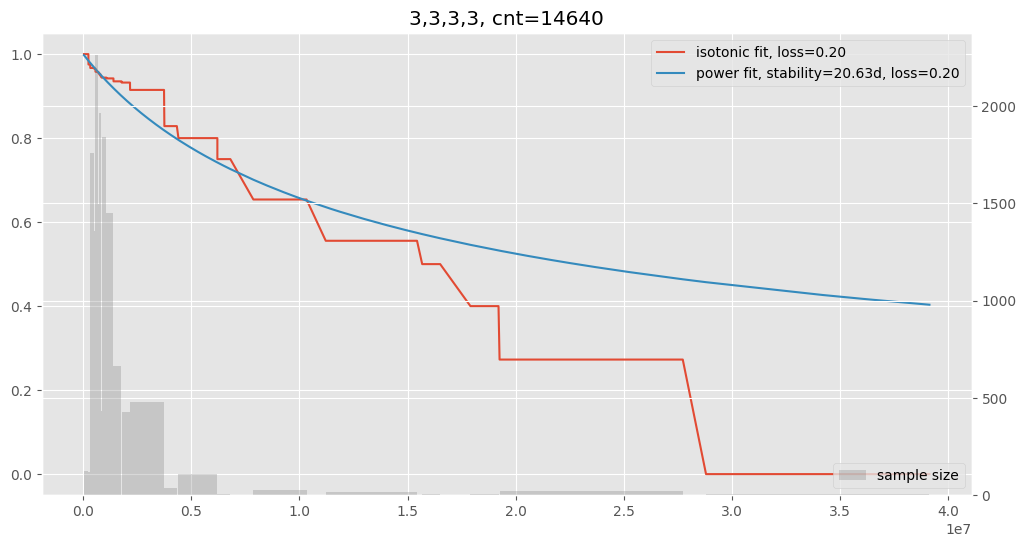

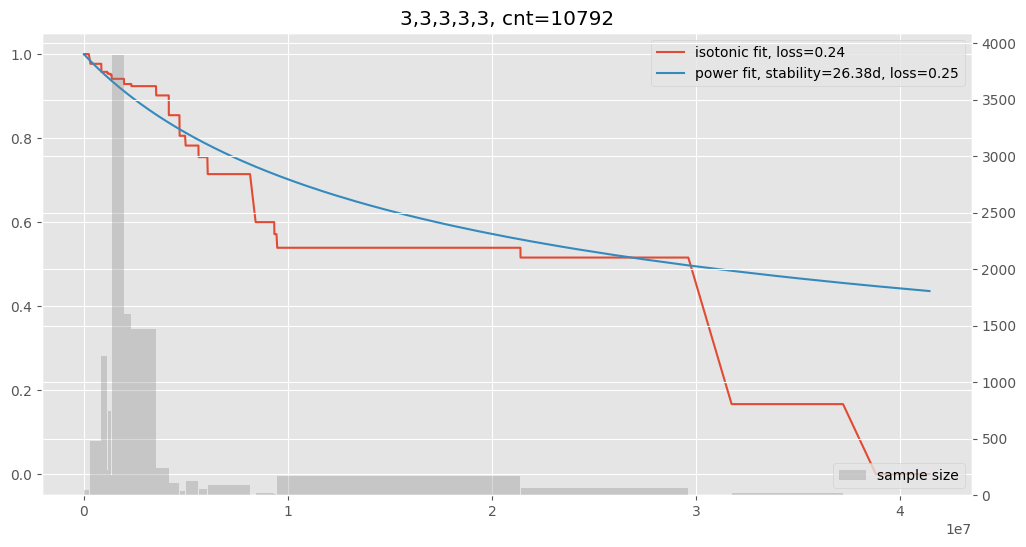

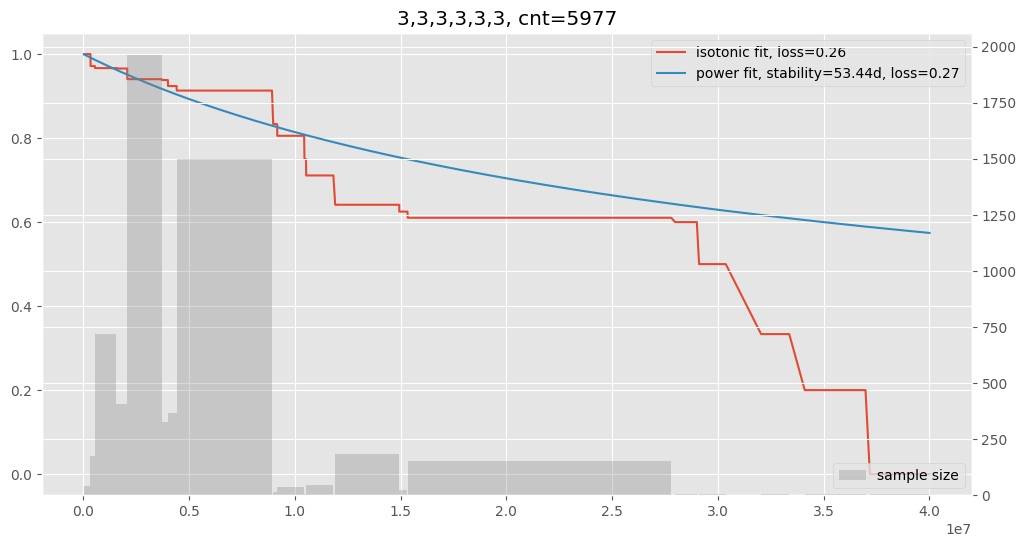

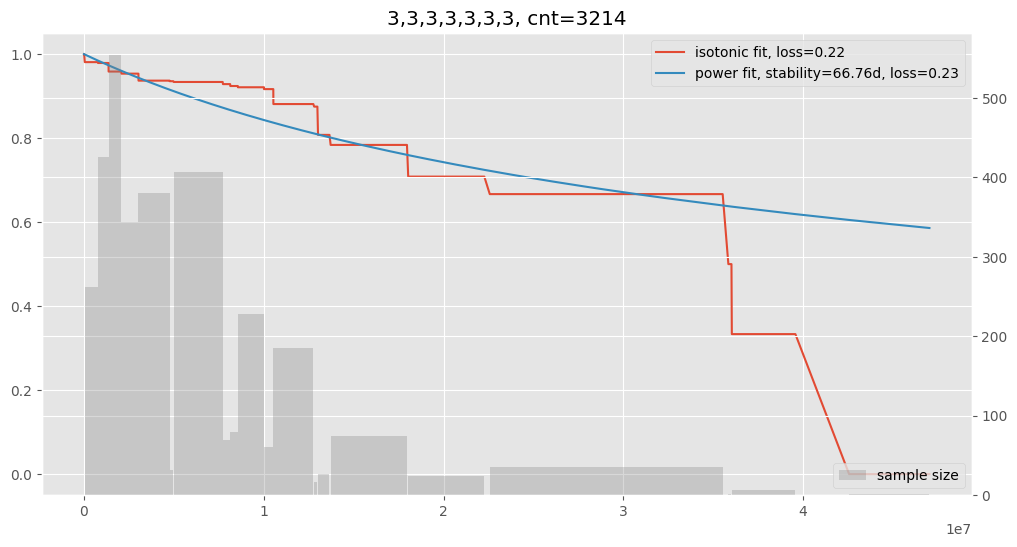

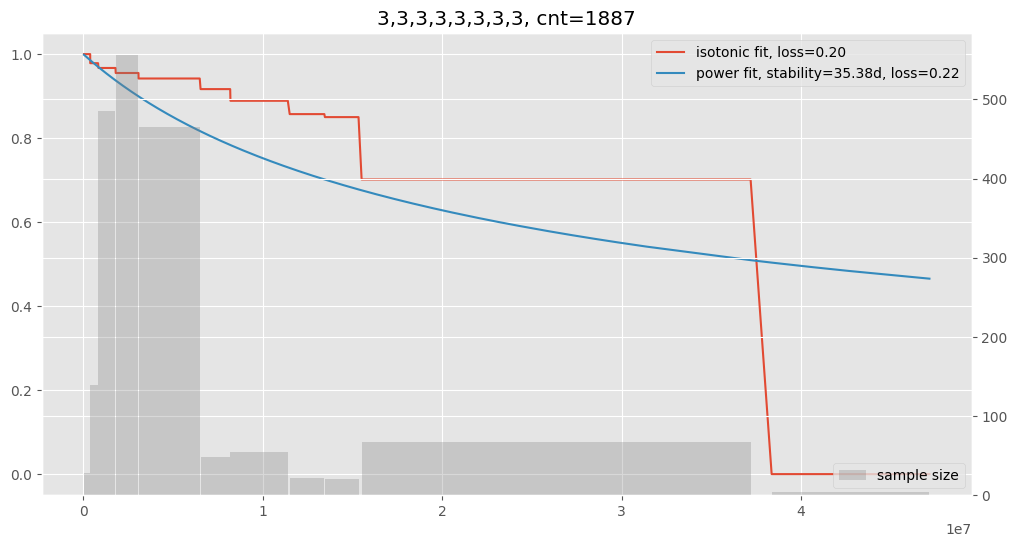

In [2]:
DECAY = -0.5


def power_forgetting_curve(t, s, decay=DECAY):
    factor = 0.9 ** (1 / decay) - 1
    return (1 + factor * t / s) ** decay


def fit_stability(delta_t, retention, size, decay=DECAY):

    def loss(stability):
        y_pred = power_forgetting_curve(delta_t, stability, decay)
        loss = sum(
            -(retention * np.log(y_pred) + (1 - retention) * np.log(1 - y_pred)) * size
        )
        return loss

    res = minimize(loss, x0=1, bounds=[(0.1, None)])
    return res.x[0]

for r_history in (
    "1",
    "1,2",
    "1,3",
    "1,3,3",
    "1,3,3,3",
    "2",
    "2,2",
    "2,3",
    "2,3,3",
    "3",
    "3,2",
    "3,3",
    "3,3,3",
    "3,3,3,3",
    "3,3,3,3,3",
    "3,3,3,3,3,3",
    "3,3,3,3,3,3,3",
    "3,3,3,3,3,3,3,3",
):

    x, y = df[df['r_history'] == r_history][['delta_t', 'y']].sort_values(by='delta_t').values.T

    if all(y == 1):
        continue
    # print(y)

    ir = IsotonicRegression(y_min=0, y_max=1, increasing=False)
    ir.fit(x, y)

    y_ir = ir.predict(x)
    loss_ir = log_loss(y, y_ir)

    s_seconds = fit_stability(x, y_ir, np.ones_like(x))
    s = f"{s_seconds:.2f}s" if s_seconds < 60 else (
        f"{s_seconds/60:.2f}min" if s_seconds < 3600 else (
            f"{s_seconds/3600:.2f}h" if s_seconds < 86400 else 
            f"{s_seconds/86400:.2f}d"
        )
    )
    y_pred = power_forgetting_curve(x, s_seconds)
    loss = log_loss(y, y_pred)
    cnt = len(x)

    # print(y_pred)
    fig, ax1 = plt.subplots(figsize=(12, 6))
    # ax1.plot(x, y, 'o', label='data')
    ax1.plot(x, y_ir, '-', label=f'isotonic fit, loss={loss_ir:.2f}')
    ax1.plot(x, y_pred, '-', label=f'power fit, stability={s}, loss={loss:.2f}')


    unique_y_ir = np.unique(y_ir)
    segment_counts = []
    segment_x = []
    segment_widths = []
    for i in range(len(unique_y_ir)):
        mask = y_ir == unique_y_ir[i]
        segment_counts.append(np.sum(mask))
        segment_x.append(np.min(x[mask]))
        segment_widths.append(np.max(x[mask]) - np.min(x[mask])) 
    
    ax2 = ax1.twinx()
    ax2.bar(segment_x, segment_counts, alpha=0.3, width=segment_widths, color='gray', label='sample size', align='edge')
    ax1.set_title(f'{r_history}, cnt={cnt}')
    ax1.legend(loc='upper right')
    ax2.legend(loc='lower right')
    plt.show()